## Communication Evolution with Gradual Chunk

here we extends the convention-formation framework from Notebook 3 to study cultural evolution of communication systems

We fixed the meaning: tower program never changes across generations

We expect the lexicon (mapping words to meaning) and the inventory of speaker's active chunk abstractions to evolve.

Models:

- random_utt: Random utterance 
- literal_step: Sample from lexicon belief (LearningAgent)
- rsa_step: RSA-weighted utterance choice (ablation of whether mes_len dep on program choice)
- rsa_program: RSA program-choice + utterance, with gradual chunk promotion.  (StrategicAgent)

Gradual chunk promotion: a gate that filter innovated and stabilized chunk to become reusable, for understandability of listeners.

An ablation of chunk gate also perfromed, to showcase the stabilized of the abstraction emergence.

In [1]:
import os
import sys
import random
from concurrent.futures import ProcessPoolExecutor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make project root importable
if os.path.basename(os.getcwd()) == "notebooks_new":
    ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
else:
    ROOT_DIR = os.path.abspath(os.getcwd())
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

from model.transmission.transmission_chain import run_comm_chain_bayes_rsa, _run_comm_worker

In [ ]:
SEED = 42
SHOW_PLOTS = True
USE_PARALLEL = True
OUT_DIR = os.path.join(ROOT_DIR, "results", "comm")

COMM_PPT_ID = 1 # Participant 1's trial sequence from `data/model/programs_for_you/`
COMM_NUM_GENERATIONS = 50
COMM_SOURCE_SUBDIR = "programs_for_you"
COMM_LEXEMES = ["blah", "blab", "bloop", "bleep", "floop"]

# Chunk promotion parameters (stricter for gradual evolution)
COMM_MIN_ATTEMPTS = 5       # times have to repeat
COMM_MIN_SUCCESS_RATE = 0.3 # listener's success rate of the chunk
COMM_P_INNOVATE = 0.10      # prob of a new chunk
COMM_PRE_PROMOTE_CHUNK_CORRECT = 0.6 # listener's success rate of chunk unpromoted
COMM_MAX_PROMOTE_PER_GEN = 1 # max number of chunks promoted per generation

# Speaker parameters
COMM_SPEAKER_ALPHA_PROG = 2.0   # softmax temperature for program-choice
COMM_SPEAKER_ALPHA_UTT = 2.0    # softmax temperature for utterance-choice
COMM_SPEAKER_BETA_COST = 0.3    # cost of chunk usage
COMM_EPSILON = 0.01             # epsilon-greedy for program-choice

COMM_SPEAKER_MODES = ["random_utt", "literal_step", "rsa_step", "rsa_program"]
COLORS = {"random_utt": "tab:gray", "literal_step": "tab:orange",
          "rsa_step": "tab:green", "rsa_program": "tab:red"}


random.seed(SEED)
np.random.seed(SEED)


In [4]:
def run_all_models():
    os.makedirs(OUT_DIR, exist_ok=True)

    base_args = {
        "ppt_id": COMM_PPT_ID,
        "data_model_dir": os.path.join(ROOT_DIR, "data", "model"),
        "num_generations": COMM_NUM_GENERATIONS,
        "lexemes": COMM_LEXEMES,
        "min_attempts": COMM_MIN_ATTEMPTS,
        "min_success_rate": COMM_MIN_SUCCESS_RATE,
        "p_innovate": COMM_P_INNOVATE,
        "pre_promote_chunk_correct": COMM_PRE_PROMOTE_CHUNK_CORRECT,
        "max_promote_per_gen": COMM_MAX_PROMOTE_PER_GEN,
        "speaker_alpha_prog": COMM_SPEAKER_ALPHA_PROG,
        "speaker_alpha_utt": COMM_SPEAKER_ALPHA_UTT,
        "speaker_beta_cost": COMM_SPEAKER_BETA_COST,
        "epsilon": COMM_EPSILON,
        "random_seed": SEED,
        "source_subdir": COMM_SOURCE_SUBDIR,
    }

    jobs = []
    for mode in COMM_SPEAKER_MODES:
        job = dict(base_args)
        job["speaker_mode"] = mode
        jobs.append(job)

    print("Running 4 models...")
    if USE_PARALLEL:
        with ProcessPoolExecutor(max_workers=4) as pool:
            results = list(pool.map(_run_comm_worker, jobs))
    else:
        results = [_run_comm_worker(j) for j in jobs]

    comm_df = pd.concat(results, ignore_index=True)
    comm_df.to_csv(os.path.join(OUT_DIR, "comm_by_gen.csv"), index=False)
    print(f"Results saved to {OUT_DIR}/")
    return comm_df, base_args

def run_control(base_args):
    print("Running gated vs no-gate control...")
    control_jobs = [
        {**base_args, "speaker_mode": "rsa_program",
         "min_attempts": 0, "min_success_rate": 0.0, "p_innovate": 1.0,
         "pre_promote_chunk_correct": 1.0, "max_promote_per_gen": 99, "variant": "no_gate"},
        {**base_args, "speaker_mode": "rsa_program", "variant": "gated"},
    ]

    if USE_PARALLEL:
        with ProcessPoolExecutor(max_workers=2) as pool:
            control_results = list(pool.map(_run_comm_worker, control_jobs))
    else:
        control_results = [_run_comm_worker(j) for j in control_jobs]

    return pd.concat(control_results, ignore_index=True)


Each model runs for generations on the same trial sequence.
At each generation:
1. Speaker communicates the fixed meanings using its strategy
2. Listener interprets utterances using Bayesian lexicon inference
3. Beliefs are updated for the next generation (iterated learning)

In [5]:
comm_df, base_args = run_all_models()

Running 4 models...
Results saved to /Users/apple/git/compositional-abstractions-tutorial/results/comm/


In [6]:
summary = comm_df.groupby("model")[["acc_comm", "msg_len", "frag_rate", "num_active_chunks"]].agg(["mean", "min", "max"])

summary

acc_comm                        msg_len                        \
                  mean       min       max       mean        min        max   
model                                                                         
literal_step  0.780366  0.707317  0.835366  13.666667  13.666667  13.666667   
random_utt    0.033171  0.000000  0.067073  13.666667  13.666667  13.666667   
rsa_program   0.776455  0.681818  0.862500   9.723333   6.666667  13.666667   
rsa_step      0.775366  0.713415  0.847561  13.666667  13.666667  13.666667   

             frag_rate              num_active_chunks            
                  mean  min     max              mean  min  max  
model                                                            
literal_step  0.000000  0.0  0.0000              0.00  0.0  0.0  
random_utt    0.000000  0.0  0.0000              0.00  0.0  0.0  
rsa_program   0.105191  0.0  0.2125              2.52  0.0  4.0  
rsa_step      0.000000  0.0  0.0000              0.00  0.0  0.0

per step:

acc_comm: Communication accuracy mean(response == intention)

msg_len: Mean message length per communicated program.

frag_rate: Chunk abstractions rate.

num_active_chunks: Number of chunks that have been promoted

In [48]:
COMM_SPEAKER_MODES = ['literal_step', 'rsa_step', 'rsa_program']

# plot of random_utt is relatively meaningless

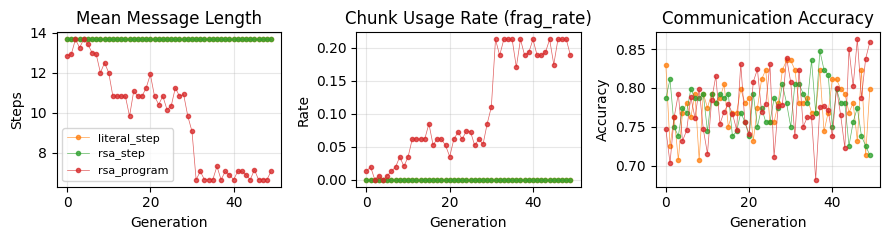

In [52]:
if SHOW_PLOTS:
    fig, axes = plt.subplots(1, 3, figsize=(9, 2.5))

    for mode in COMM_SPEAKER_MODES:
        sub = comm_df[comm_df["model"] == mode]
        c = COLORS[mode]
        axes[0].plot(sub["generation"], sub["msg_len"], marker=".", lw=.5, alpha=0.75, color=c, label=mode)
        axes[1].plot(sub["generation"], sub["frag_rate"], marker=".", lw=.5, alpha=0.75, color=c, label=mode)
        axes[2].plot(sub["generation"], sub["acc_comm"], marker=".", lw=.5, alpha=0.75, color=c, label=mode)

    axes[0].set_xlabel("Generation")
    axes[0].set_ylabel("Steps")
    axes[0].set_title("Mean Message Length")
    axes[0].legend(fontsize=8)
    axes[0].grid(alpha=0.3)

    axes[1].set_xlabel("Generation")
    axes[1].set_ylabel("Rate")
    axes[1].set_title("Chunk Usage Rate (frag_rate)")
    axes[1].grid(alpha=0.3)

    axes[2].set_xlabel("Generation")
    axes[2].set_ylabel("Accuracy")
    axes[2].set_title("Communication Accuracy")
    axes[2].grid(alpha=0.3)
    

    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "core_3_plots.png"), dpi=150)
    plt.show()


In [72]:
COMM_NUM_GENERATIONS = 100
COMM_MIN_ATTEMPTS = 5
COMM_MIN_SUCCESS_RATE = 0.5
COMM_P_INNOVATE = 0.075
COMM_PRE_PROMOTE_CHUNK_CORRECT = 0.55

base_args = {
        "ppt_id": COMM_PPT_ID,
        "data_model_dir": os.path.join(ROOT_DIR, "data", "model"),
        "num_generations": COMM_NUM_GENERATIONS,
        "lexemes": COMM_LEXEMES,
        "min_attempts": COMM_MIN_ATTEMPTS,
        "min_success_rate": COMM_MIN_SUCCESS_RATE,
        "p_innovate": COMM_P_INNOVATE,
        "pre_promote_chunk_correct": COMM_PRE_PROMOTE_CHUNK_CORRECT,
        "max_promote_per_gen": COMM_MAX_PROMOTE_PER_GEN,
        "speaker_alpha_prog": COMM_SPEAKER_ALPHA_PROG,
        "speaker_alpha_utt": COMM_SPEAKER_ALPHA_UTT,
        "speaker_beta_cost": COMM_SPEAKER_BETA_COST,
        "epsilon": COMM_EPSILON,
        "random_seed": SEED,
        "source_subdir": COMM_SOURCE_SUBDIR,
    }

In [73]:
control_df = run_control(base_args)


Running gated vs no-gate control...


In [74]:
control_df.head()

,generation,acc_comm,msg_len,frag_rate,ppt_id,speaker_mode,num_active_chunks,max_candidate_attempts,max_candidate_success_rate,model,variant
0,0.0,0.773913,9.583333,0.086957,1.0,rsa_program,3.0,5.0,0.0,rsa_program,no_gate
1,1.0,0.731959,8.083333,0.134021,1.0,rsa_program,4.0,5.0,0.0,rsa_program,no_gate
2,2.0,0.769231,7.583333,0.164835,1.0,rsa_program,4.0,5.0,0.0,rsa_program,no_gate
3,3.0,0.802198,7.583333,0.153846,1.0,rsa_program,4.0,5.0,0.0,rsa_program,no_gate
4,4.0,0.775000,6.666667,0.212500,1.0,rsa_program,4.0,5.0,0.0,rsa_program,no_gate


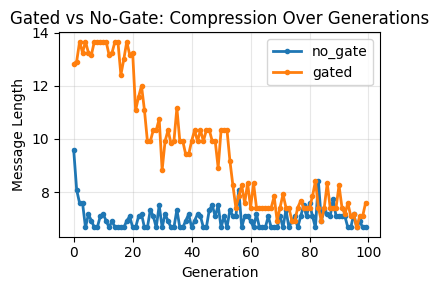

In [75]:
if SHOW_PLOTS:
    fig = plt.figure(figsize=(4, 3))
    ax0 = fig.add_subplot(111)
    for variant in ["no_gate", "gated"]:
        sub = control_df[control_df["variant"] == variant]
        ax0.plot(sub["generation"], sub["msg_len"], marker=".", lw=2, label=variant)

    ax0.set_xlabel("Generation")
    ax0.set_ylabel("Message Length")
    ax0.set_title("Gated vs No-Gate: Compression Over Generations")
    ax0.legend()
    ax0.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "gated_vs_nogate.png"), dpi=150)
    plt.show()

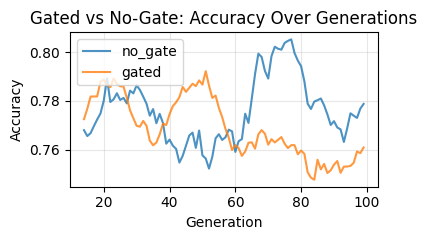

In [ ]:
# plot accuracy communication per generation for gate vs no gate
if SHOW_PLOTS:
    fig = plt.figure(figsize=(4, 2.5))
    ax0 = fig.add_subplot(111)
    # for variant in ["no_gate", "gated"]:
    #     sub = control_df[control_df["variant"] == variant]
    #     ax0.plot(sub["generation"], sub["acc_comm"], label=variant, alpha=0.8)
    # apply a moving average to both
    for variant in ["no_gate", "gated"]:
        sub = control_df[control_df["variant"] == variant]
        ax0.plot(sub["generation"], sub["acc_comm"].rolling(window=15).mean(), label=variant, alpha=0.8)

    ax0.set_xlabel("Generation")
    ax0.set_ylabel("Accuracy")
    ax0.set_title("Gated vs No-Gate: Accuracy Over Generations")
    ax0.legend()
    ax0.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "gated_vs_nogate_acc.png"), dpi=150)
    plt.show()

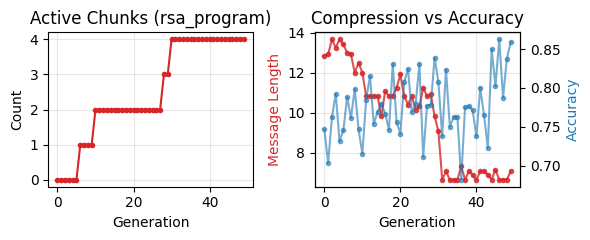

In [83]:
if SHOW_PLOTS:
    rsa_prog = comm_df[comm_df["model"] == "rsa_program"]

    fig, axes = plt.subplots(1, 2, figsize=(6, 2.5))

    axes[0].plot(rsa_prog["generation"], rsa_prog["num_active_chunks"],
                    marker=".", color="tab:red")
    axes[0].set_xlabel("Generation")
    axes[0].set_ylabel("Count")
    axes[0].set_title("Active Chunks (rsa_program)")
    axes[0].grid(alpha=0.3)

    axes[1].plot(rsa_prog["generation"], rsa_prog["msg_len"],
                    marker=".", color="tab:red", alpha=0.8, label="msg_len")

    ax2 = axes[1].twinx()
    ax2.plot(rsa_prog["generation"], rsa_prog["acc_comm"],
                marker=".", color="tab:blue", alpha=0.6, label="acc_comm")
    axes[1].set_xlabel("Generation")
    axes[1].set_ylabel("Message Length", color="tab:red")
    ax2.set_ylabel("Accuracy", color="tab:blue")
    axes[1].set_title("Compression vs Accuracy")
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "chunk_promotion.png"), dpi=150)
    plt.show()

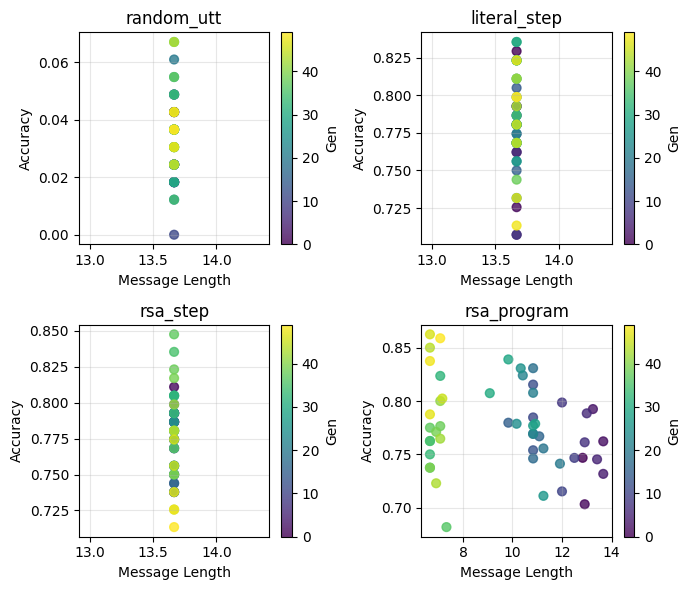

In [29]:
if SHOW_PLOTS:
    fig, axes = plt.subplots(2, 2, figsize=(7, 6))
    axes = axes.flatten()

    for i, mode in enumerate(COMM_SPEAKER_MODES):
        ax = axes[i]
        sub = comm_df[comm_df["model"] == mode]
        c = COLORS[mode]
        scatter = ax.scatter(sub["msg_len"], sub["acc_comm"],
                                c=sub["generation"], cmap="viridis", s=40, alpha=0.8)
        # ax.plot(list(sub["msg_len"]), list(sub["acc_comm"]), color=c, linewidth=1, alpha=0.5)
        ax.set_xlabel("Message Length")
        ax.set_ylabel("Accuracy")
        ax.set_title(mode)
        ax.grid(alpha=0.3)
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label("Gen")

    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "efficiency_frontier.png"), dpi=150)
    plt.show()


In [65]:
'''if SHOW_PLOTS:
    # Plot efficiency frontier of rsa_program of first 30 generations
    rsa_prog = comm_df[comm_df["model"] == "rsa_program"].head(30)
    fig, ax = plt.subplots(figsize=(3.5, 3))
    ax.scatter(rsa_prog["msg_len"], rsa_prog["acc_comm"],
               c=rsa_prog["generation"], cmap="viridis", s=40, alpha=0.8)
    ax.set_xlabel("Message Length")
    ax.set_ylabel("Accuracy")
    ax.set_title("Efficiency Frontier (rsa_program)")
    ax.grid(alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("Gen")

    # add a line that connects average acc of each msg_len
    avg_acc = rsa_prog.groupby("msg_len")["acc_comm"].mean()
    ax.plot(avg_acc.index, avg_acc.values, color="tab:red", label="Avg Acc")
    ax.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "efficiency_frontier_rsa_program.png"), dpi=150)
    plt.show()
'''

'if SHOW_PLOTS:\n    # Plot efficiency frontier of rsa_program of first 30 generations\n    rsa_prog = comm_df[comm_df["model"] == "rsa_program"].head(30)\n    fig, ax = plt.subplots(figsize=(3.5, 3))\n    ax.scatter(rsa_prog["msg_len"], rsa_prog["acc_comm"],\n               c=rsa_prog["generation"], cmap="viridis", s=40, alpha=0.8)\n    ax.set_xlabel("Message Length")\n    ax.set_ylabel("Accuracy")\n    ax.set_title("Efficiency Frontier (rsa_program)")\n    ax.grid(alpha=0.3)\n    cbar = plt.colorbar(scatter, ax=ax)\n    cbar.set_label("Gen")\n\n    # add a line that connects average acc of each msg_len\n    avg_acc = rsa_prog.groupby("msg_len")["acc_comm"].mean()\n    ax.plot(avg_acc.index, avg_acc.values, color="tab:red", label="Avg Acc")\n    ax.legend()\n\n    plt.tight_layout()\n    plt.savefig(os.path.join(OUT_DIR, "efficiency_frontier_rsa_program.png"), dpi=150)\n    plt.show()\n'